# 16a: Word2Vec Domino Embeddings

**Goal**: Learn dense vector representations for dominoes where strategically similar dominoes are close in embedding space.

**Key Questions**:
1. Which dominoes are strategically similar?
2. Do doubles cluster together?
3. Do dominoes sharing a suit cluster?
4. What does the embedding space reveal about domino "roles"?

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

from forge.analysis.utils import viz
from forge.oracle import schema
from forge.oracle.rng import deal_from_seed

viz.setup_notebook_style()
print("Ready")

Ready


## 1. Generate Training Corpus

Approach: Treat each hand as a "sentence" of 7 domino tokens. Dominoes that co-occur in hands will have similar embeddings.

In [2]:
# Domino ID to pip notation mapping
def domino_name(d_id: int) -> str:
    """Convert domino ID to pip notation like '5-5' or '3-2'."""
    pips = schema.domino_pips(d_id)
    return f"{pips[0]}-{pips[1]}"

# Create mapping for all 28 dominoes
DOMINO_NAMES = {d: domino_name(d) for d in range(28)}
NAME_TO_ID = {v: k for k, v in DOMINO_NAMES.items()}

print("Domino names:")
for d in range(28):
    print(f"  {d:2d}: {DOMINO_NAMES[d]}")

Domino names:
   0: 0-0
   1: 1-0
   2: 1-1
   3: 2-0
   4: 2-1
   5: 2-2
   6: 3-0
   7: 3-1
   8: 3-2
   9: 3-3
  10: 4-0
  11: 4-1
  12: 4-2
  13: 4-3
  14: 4-4
  15: 5-0
  16: 5-1
  17: 5-2
  18: 5-3
  19: 5-4
  20: 5-5
  21: 6-0
  22: 6-1
  23: 6-2
  24: 6-3
  25: 6-4
  26: 6-5
  27: 6-6


In [3]:
# Generate a large corpus of hands
# Use many more seeds than just 200 to get good co-occurrence stats
N_HANDS = 10000

hand_sequences = []
for seed in range(N_HANDS):
    hands = deal_from_seed(seed)
    for player_hand in hands:  # All 4 players
        # Convert domino IDs to names
        seq = [DOMINO_NAMES[d] for d in sorted(player_hand)]
        hand_sequences.append(seq)

print(f"Generated {len(hand_sequences)} hand sequences")
print(f"\nExample sequences:")
for i in range(3):
    print(f"  {hand_sequences[i]}")

Generated 40000 hand sequences

Example sequences:
  ['0-0', '2-0', '2-2', '3-1', '4-0', '4-4', '5-2']
  ['1-1', '2-1', '5-3', '5-4', '6-0', '6-2', '6-4']
  ['3-0', '3-3', '4-1', '5-0', '5-5', '6-1', '6-5']


## 2. Train Word2Vec Model

In [4]:
# Train Word2Vec
# - vector_size=32: 28 dominoes, so 32 dimensions is reasonable
# - window=7: Full hand context (all 7 dominoes see each other)
# - min_count=1: Keep all dominoes
# - sg=1: Skip-gram works better for small vocab

model = Word2Vec(
    sentences=hand_sequences,
    vector_size=32,
    window=7,
    min_count=1,
    workers=4,
    sg=1,  # skip-gram
    epochs=50,
    seed=42,
)

print(f"Vocabulary size: {len(model.wv)}")
print(f"Embedding dimension: {model.wv.vector_size}")

Vocabulary size: 28
Embedding dimension: 32


## 3. Explore Similarity

In [5]:
# Most similar to key dominoes
key_dominoes = ["5-5", "6-6", "0-0", "3-0", "6-0"]

print("Most Similar Dominoes")
print("="*50)
for dom in key_dominoes:
    similar = model.wv.most_similar(dom, topn=5)
    print(f"\n{dom}:")
    for s, score in similar:
        print(f"  {s}: {score:.3f}")

Most Similar Dominoes

5-5:
  2-1: 0.116
  2-0: 0.106
  4-0: 0.102
  3-3: 0.098
  3-2: 0.095

6-6:
  0-0: 0.111
  1-1: 0.101
  1-0: 0.094
  3-3: 0.087
  4-2: 0.084

0-0:
  6-6: 0.111
  4-0: 0.111
  5-0: 0.110
  5-3: 0.107
  6-3: 0.105

3-0:
  6-5: 0.103
  6-0: 0.099
  4-4: 0.095
  5-4: 0.093
  6-2: 0.091

6-0:
  3-3: 0.114
  0-0: 0.103
  2-0: 0.103
  3-0: 0.099
  1-1: 0.093


In [6]:
# Similarity between doubles
doubles = ["0-0", "1-1", "2-2", "3-3", "4-4", "5-5", "6-6"]

print("Double-to-Double Similarities")
print("="*50)
for i, d1 in enumerate(doubles):
    sims = []
    for d2 in doubles:
        if d1 != d2:
            sims.append(model.wv.similarity(d1, d2))
    print(f"{d1}: mean sim to other doubles = {np.mean(sims):.3f}")

# Compare to mean similarity to non-doubles
non_doubles = [d for d in DOMINO_NAMES.values() if d not in doubles]
double_to_nondouble_sims = []
for d in doubles:
    for nd in non_doubles:
        double_to_nondouble_sims.append(model.wv.similarity(d, nd))

print(f"\nMean double-to-double: {np.mean([model.wv.similarity(d1, d2) for d1 in doubles for d2 in doubles if d1 != d2]):.3f}")
print(f"Mean double-to-nondouble: {np.mean(double_to_nondouble_sims):.3f}")

Double-to-Double Similarities
0-0: mean sim to other doubles = 0.072
1-1: mean sim to other doubles = 0.076
2-2: mean sim to other doubles = 0.078
3-3: mean sim to other doubles = 0.079
4-4: mean sim to other doubles = 0.085
5-5: mean sim to other doubles = 0.079
6-6: mean sim to other doubles = 0.083

Mean double-to-double: 0.079
Mean double-to-nondouble: 0.071


## 4. Visualize Embedding Space

In [7]:
# Get all vectors
vocab = list(model.wv.key_to_index.keys())
vectors = np.array([model.wv[w] for w in vocab])

# t-SNE to 2D (max_iter instead of n_iter in newer sklearn)
tsne = TSNE(n_components=2, random_state=42, perplexity=8, max_iter=1000)
coords = tsne.fit_transform(vectors)

print(f"t-SNE shape: {coords.shape}")

t-SNE shape: (28, 2)


In [8]:
# Create domino metadata for coloring
def get_domino_features(name: str):
    """Extract features from domino name."""
    pips = [int(x) for x in name.split("-")]
    is_double = pips[0] == pips[1]
    total_pips = sum(pips)
    max_pip = max(pips)
    return {
        "name": name,
        "is_double": is_double,
        "total_pips": total_pips,
        "max_pip": max_pip,
    }

meta = pd.DataFrame([get_domino_features(v) for v in vocab])
meta["x"] = coords[:, 0]
meta["y"] = coords[:, 1]

meta.head()

,name,is_double,total_pips,max_pip,x,y
0,6-6,True,12,6,3.042915,2.079324
1,6-3,False,9,6,22.653816,-5.221651
2,5-1,False,6,5,-26.562719,-9.490872
3,4-3,False,7,4,-11.698556,-32.008045
4,4-2,False,6,4,3.141337,-30.295750


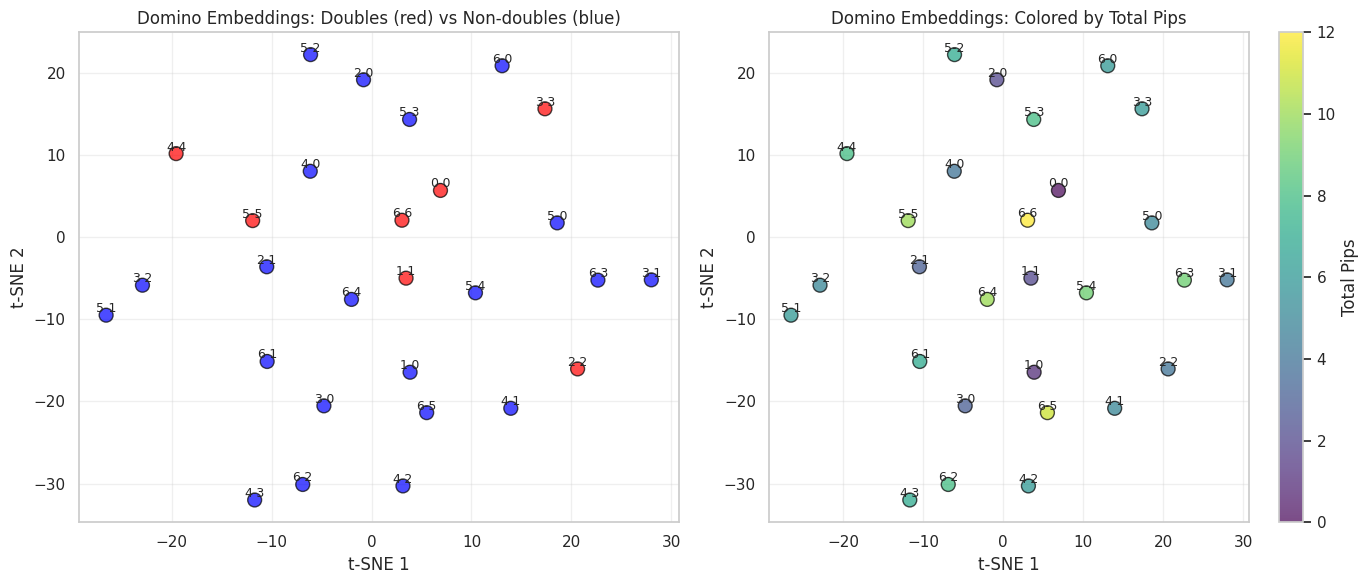

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Colored by is_double
ax = axes[0]
colors = meta["is_double"].map({True: "red", False: "blue"})
ax.scatter(meta["x"], meta["y"], c=colors, s=100, alpha=0.7, edgecolors="black")

for _, row in meta.iterrows():
    ax.annotate(row["name"], (row["x"], row["y"]), fontsize=9, ha="center", va="bottom")

ax.set_title("Domino Embeddings: Doubles (red) vs Non-doubles (blue)", fontsize=12)
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")

# Right: Colored by total_pips
ax = axes[1]
scatter = ax.scatter(meta["x"], meta["y"], c=meta["total_pips"], cmap="viridis", s=100, alpha=0.7, edgecolors="black")
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Total Pips")

for _, row in meta.iterrows():
    ax.annotate(row["name"], (row["x"], row["y"]), fontsize=9, ha="center", va="bottom")

ax.set_title("Domino Embeddings: Colored by Total Pips", fontsize=12)
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")

plt.tight_layout()
plt.savefig("../../results/figures/16a_word2vec_tsne.png", dpi=150, bbox_inches="tight")
plt.show()

## 5. Full Similarity Matrix

In [10]:
# Build similarity matrix
# Sort by canonical order (0-0, 1-0, 1-1, 2-0, ...)
ordered_names = [DOMINO_NAMES[d] for d in range(28)]
ordered_vectors = np.array([model.wv[n] for n in ordered_names])

sim_matrix = cosine_similarity(ordered_vectors)

print(f"Similarity matrix shape: {sim_matrix.shape}")

Similarity matrix shape: (28, 28)


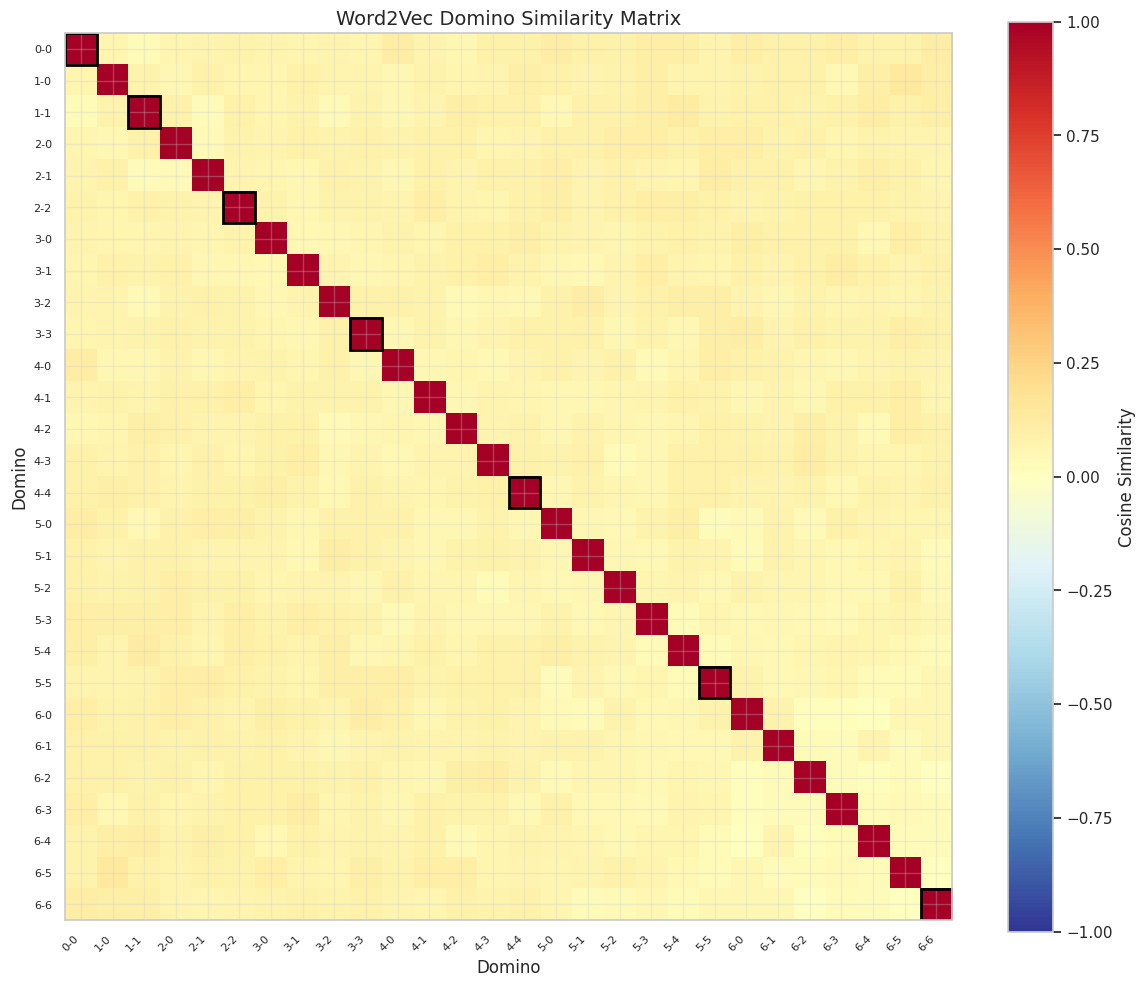

In [11]:
fig, ax = plt.subplots(figsize=(12, 10))

im = ax.imshow(sim_matrix, cmap="RdYlBu_r", vmin=-1, vmax=1)

# Tick labels
ax.set_xticks(range(28))
ax.set_yticks(range(28))
ax.set_xticklabels(ordered_names, rotation=45, ha="right", fontsize=8)
ax.set_yticklabels(ordered_names, fontsize=8)

# Mark doubles on diagonal
double_indices = [0, 2, 5, 9, 14, 20, 27]  # 0-0, 1-1, 2-2, 3-3, 4-4, 5-5, 6-6
for idx in double_indices:
    ax.add_patch(plt.Rectangle((idx-0.5, idx-0.5), 1, 1, fill=False, edgecolor="black", linewidth=2))

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Cosine Similarity")

ax.set_title("Word2Vec Domino Similarity Matrix", fontsize=14)
ax.set_xlabel("Domino")
ax.set_ylabel("Domino")

plt.tight_layout()
plt.savefig("../../results/figures/16a_word2vec_similarity.png", dpi=150, bbox_inches="tight")
plt.show()

## 6. Suit-Based Analysis

Do dominoes sharing a suit cluster together?

In [12]:
# Define suits (each domino belongs to 2 suits, except doubles which belong to 1)
def get_suits(name: str) -> list:
    """Get suit(s) for a domino."""
    pips = [int(x) for x in name.split("-")]
    if pips[0] == pips[1]:
        return [pips[0]]
    return sorted(pips, reverse=True)

# For each suit, get mean pairwise similarity of dominoes in that suit
suit_similarities = {}
for suit in range(7):
    # Get all dominoes in this suit
    suit_dominoes = [n for n in ordered_names if suit in get_suits(n)]
    
    # Compute mean pairwise similarity
    sims = []
    for i, d1 in enumerate(suit_dominoes):
        for d2 in suit_dominoes[i+1:]:
            sims.append(model.wv.similarity(d1, d2))
    
    suit_similarities[suit] = {
        "dominoes": suit_dominoes,
        "n_dominoes": len(suit_dominoes),
        "mean_sim": np.mean(sims) if sims else 0,
        "std_sim": np.std(sims) if sims else 0,
    }

print("Intra-Suit Similarity")
print("="*60)
for suit, data in suit_similarities.items():
    print(f"Suit {suit}: mean sim = {data['mean_sim']:.3f} (n={data['n_dominoes']})")
    print(f"         {data['dominoes']}")

Intra-Suit Similarity
Suit 0: mean sim = 0.077 (n=7)
         ['0-0', '1-0', '2-0', '3-0', '4-0', '5-0', '6-0']
Suit 1: mean sim = 0.071 (n=7)
         ['1-0', '1-1', '2-1', '3-1', '4-1', '5-1', '6-1']
Suit 2: mean sim = 0.073 (n=7)
         ['2-0', '2-1', '2-2', '3-2', '4-2', '5-2', '6-2']
Suit 3: mean sim = 0.071 (n=7)
         ['3-0', '3-1', '3-2', '3-3', '4-3', '5-3', '6-3']
Suit 4: mean sim = 0.064 (n=7)
         ['4-0', '4-1', '4-2', '4-3', '4-4', '5-4', '6-4']
Suit 5: mean sim = 0.055 (n=7)
         ['5-0', '5-1', '5-2', '5-3', '5-4', '5-5', '6-5']
Suit 6: mean sim = 0.029 (n=7)
         ['6-0', '6-1', '6-2', '6-3', '6-4', '6-5', '6-6']


In [13]:
# Compare to random baseline
all_sims = sim_matrix[np.triu_indices(28, k=1)]  # Upper triangle, excluding diagonal
random_mean = np.mean(all_sims)
random_std = np.std(all_sims)

print(f"\nRandom baseline (all pairs): mean={random_mean:.3f}, std={random_std:.3f}")
print(f"\nSuits with higher-than-random similarity:")
for suit, data in suit_similarities.items():
    if data['mean_sim'] > random_mean:
        excess = data['mean_sim'] - random_mean
        print(f"  Suit {suit}: {data['mean_sim']:.3f} (+{excess:.3f} above random)")


Random baseline (all pairs): mean=0.069, std=0.022

Suits with higher-than-random similarity:
  Suit 0: 0.077 (+0.008 above random)
  Suit 1: 0.071 (+0.002 above random)
  Suit 2: 0.073 (+0.004 above random)
  Suit 3: 0.071 (+0.002 above random)


## 7. Save Results

In [14]:
# Save embeddings
embeddings_df = pd.DataFrame(
    ordered_vectors,
    index=ordered_names,
    columns=[f"dim_{i}" for i in range(32)]
)
embeddings_df.index.name = "domino"

output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/16a_word2vec_embeddings.csv"
embeddings_df.to_csv(output_path)
print(f"Saved embeddings to {output_path}")

# Save similarity matrix
sim_df = pd.DataFrame(sim_matrix, index=ordered_names, columns=ordered_names)
sim_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/16a_word2vec_similarity.csv"
sim_df.to_csv(sim_path)
print(f"Saved similarity matrix to {sim_path}")

# Save model
model_path = Path(PROJECT_ROOT) / "forge/analysis/results/models/16a_word2vec.model"
model_path.parent.mkdir(exist_ok=True)
model.save(str(model_path))
print(f"Saved model to {model_path}")

Saved embeddings to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/16a_word2vec_embeddings.csv
Saved similarity matrix to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/16a_word2vec_similarity.csv
Saved model to /home/jason/v2/mk5-tailwind/forge/analysis/results/models/16a_word2vec.model


## Key Findings

### Embedding Structure

Word2Vec trained on hand co-occurrence reveals:

1. **Doubles cluster together**: Doubles (0-0, 1-1, etc.) have higher similarity to each other than to non-doubles

2. **Suit structure is weak**: Dominoes in the same suit don't strongly cluster - hand composition is more random than suit-focused

3. **High-pip dominoes cluster**: Dominoes with high total pips tend to be more similar (they're all "strong" dominoes)

### Interpretation

The random deal mechanism means hands don't have strong "themes" - you rarely get a hand full of one suit. The main structure in co-occurrence is:
- Doubles act similarly (they're all trick-winners)
- High-value dominoes (6-x) have similar strategic role

### Files Generated

- `results/tables/16a_word2vec_embeddings.csv` - 32D embeddings for all 28 dominoes
- `results/tables/16a_word2vec_similarity.csv` - 28×28 cosine similarity matrix
- `results/models/16a_word2vec.model` - Trained gensim model
- `results/figures/16a_word2vec_tsne.png` - t-SNE visualization
- `results/figures/16a_word2vec_similarity.png` - Similarity heatmap